# Advance use of Recurrent Networks

We’ll review three advanced techniques for improving the performance and generalization power of recurrent neural networks. We’ll demonstrate all three concepts on a temperature-forecasting problem, where we have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 24 hours after the last data point. We’ll cover the following techniques:
 - **Recurrent dropout—** This is a specific, built-in way to use dropout to fight overfitting in recurrent layers.
 - **Stacking recurrent layers—** This increases the representational power of the network (at the cost of higher computational loads).
 - **Bidirectional recurrent layers—** These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.
 
### Temperature-Forecasting Problem

Link: https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In this dataset, 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. The original data goes back to 2003, but this example is limited to data from 2009–2016. This dataset is perfect for learning to work with numerical timeseries. We’ll use it to build a model that takes as input some data from the recent past (a few days’ worth of data points) and predicts the air temperature 24 hours in the future.

### Inspect The Data of Jena Weather Dataset

In [1]:
import os

fname = os.path.join('jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Now, convert all 420,551 lines of data into a Numpy array.

### Parse the Data

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### Plott The Temperature Timeseries

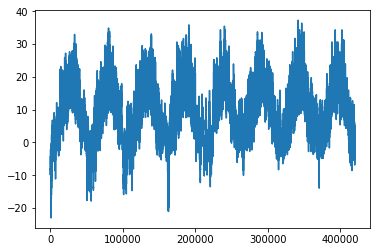

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

### Plot The First 10 Days of The Temperature Timeseries
Here is a more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, we get 144 data points per day.

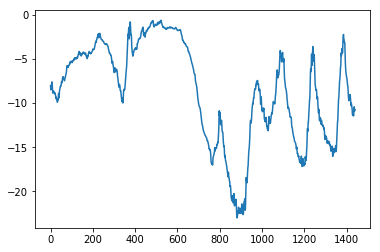

In [5]:
plt.plot(range(1440), temp[:1440])
plt.show()

On this plot, we can see daily periodicity, especially evident for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month.

If we were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a
lot more chaotic. Is this timeseries predictable at a daily scale? Let’s find out.

### Prepare The Data
The exact formulation of the problem will be as follows: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can we predict the temperature in delay timesteps? We’ll use the following parameter
values:
 - **`lookback = 720`** — Observations will go back 5 days.
 - **`steps = 6`** — Observations will be sampled at one data point per hour.
 - **`delay = 144`** — Targets will be 24 hours in the future.
 
To get started, you need to do two things:

 - Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, temperature is typically between -20 and +30, but atmospheric pressure, measured in mbar, is around 1,000). We’ll normalize each timeseries independently so that they all take small values on a similar scale.
 - Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, we’ll generate the samples on the fly using the original data.

We’ll preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We’re going to use the first 200,000 timesteps as training data, so compute the mean and standard deviation only on this fraction of the data.

### Normalize The Data

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Below listing shows the data generator we’ll use. It yields a tuple (samples, targets), where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:
 - **`data`** — The original array of floating-point data, which we normalized.
 - **`lookback`**— How many timesteps back the input data should go.
 - **`delay`** — How many timesteps in the future the target should be.
 - **`min_index`** and **`max_index`** — Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
 - **`shuffle`** — Whether to shuffle the samples or draw them in chronological order.
 - **`batch_size`** —The number of samples per batch.
 - **`step`** — The period, in timesteps, at which we sample data. We’ll set it to 6 in order to draw one data point every hour.
 
### Generator Yields Timeseries Samples and Their Targets

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Now, let’s use the abstract `generator` function to instantiate three generators: one for training, one for validation, and one for testing. Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the validation generator looks at the following 100,000, and the test generator looks at the remainder.

### Prepare The Training, Validation and Test Generators

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [9]:
# This is how many steps to draw from `val_gen` in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen` in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### A common-sense, non-machine-learning baseline

Before we start using black-box deep-learning models to solve the temperature prediction problem, let’s try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that we’ll have to beat in order to demonstrate the usefulness of more-advanced machine-learning models. Such common-sense baselines can be useful when we’re approaching a new problem for which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes are much more common than others. If our dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to the classification task is to always predict “A” when presented with a new sample. Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary baselines can prove surprisingly hard to beat.

In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common-sense approach is to always predict
that the temperature 24 hours from now will be equal to the temperature right now.

Let’s evaluate this approach, using the mean absolute error (MAE) metric: <br/>
`np.mean(np.abs(preds - targets))`

### Compute The Common-sense Baseline MAE

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


This yields an MAE of 0.29. Because the temperature data has been normalized to be centered on 0 and have a standard deviation of 1, this number isn’t immediately interpretable. It translates to an average absolute error of 0.29 × temperature_std degrees
Celsius: 2.57°C.

### Convert The MAE Back to a Celsius Error

In [15]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

That’s a fairly large average absolute error. Now the game is to use our knowledge of deep learning to do better.

### A Basic Machine-Learning Approach
It’s useful to try simple, cheap machine-learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity we throw at the problem is legitimate and delivers real benefits.

The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a regression problem. We use MAE as the loss. 

### Train and Evaluate a Densely Connected Model

In [11]:
from keras import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

Using TensorFlow backend.


In [12]:
model.compile(optimizer=RMSprop(), loss='mae')

In [13]:
history= model.fit_generator(train_gen, steps_per_epoch=500,
                            epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 10s 21ms/step - loss: 1.1915 - val_loss: 0.5493
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.4079 - val_loss: 0.3054
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2845 - val_loss: 0.3071
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2653 - val_loss: 0.3145
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2550 - val_loss: 0.3129
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2469 - val_loss: 0.3172
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2391 - val_loss: 0.3230
Epoch 8/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2334 - val_loss: 0.3468
Epoch 9/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2296 - val_loss: 0.3501
Epoch 10/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2247 - val_l

Let’s display the loss curves for validation and training

### Plot results

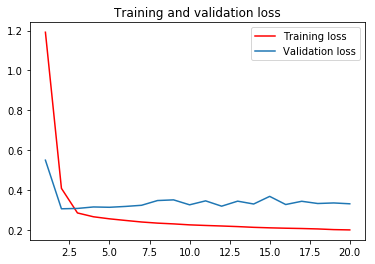

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably. This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform. Our common sense contains a lot of valuable information that a machine-learning model doesn’t have access to.

If a simple, well-performing model exists to go from the data to the targets (the common-sense baseline), why doesn’t the model we’re training find it and improve on it? Because this simple solution isn’t what our training setup is looking for. The space of models in which we’re searching for a solution—that is, our hypothesis space—is the space of all possible two-layer networks with the configuration we defined. These networks are already fairly complicated. When we’re looking for a solution with a space of complicated models, the simple, well-performing baseline may be unlearnable, even if it’s technically part of the hypothesis space. That is a pretty significant limitation of machine learning in general: unless the learning algorithm is hardcoded to look for a specific kind of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

### A First Recurrent Baseline
The first fully connected approach didn’t do well, but that doesn’t mean machine learning isn’t applicable to this problem. The previous approach first flattened the timeseries, which removed the notion of time from the input data. Let’s instead look
at the data as what it is: a sequence, where causality and order matter. We’ll try a recurrent-sequence processing model—it should be the perfect fit for such sequence data, precisely because it exploits the temporal ordering of data points, unlike the first approach.

Instead of the LSTM layer introduced in the previous section, we’ll use the GRU layer. **Gated recurrent unit (GRU)** layers work using the same principle as LSTM, but they’re somewhat streamlined and thus cheaper to run (although they may not have as much representational power as LSTM). This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.

### Train and Evaluate a GRU-based Model

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model= Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [18]:
model.compile(optimizer=RMSprop(), loss='mae')

In [19]:
history= model.fit_generator(train_gen, steps_per_epoch=500, epochs=20,
                            validation_data= val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 141s 282ms/step - loss: 0.3028 - val_loss: 0.2688
Epoch 2/20
500/500 [==============================] - 140s 280ms/step - loss: 0.2838 - val_loss: 0.2736
Epoch 3/20
500/500 [==============================] - 141s 281ms/step - loss: 0.2772 - val_loss: 0.2750
Epoch 4/20
500/500 [==============================] - 147s 294ms/step - loss: 0.2720 - val_loss: 0.2637
Epoch 5/20
500/500 [==============================] - 141s 283ms/step - loss: 0.2665 - val_loss: 0.2670
Epoch 6/20
500/500 [==============================] - 140s 281ms/step - loss: 0.2634 - val_loss: 0.2637
Epoch 7/20
500/500 [==============================] - 139s 279ms/step - loss: 0.2585 - val_loss: 0.2651
Epoch 8/20
500/500 [==============================] - 140s 280ms/step - loss: 0.2534 - val_loss: 0.2710
Epoch 9/20
500/500 [==============================] - 140s 280ms/step - loss: 0.2495 - val_loss: 0.2692
Epoch 10/20
500/500 [==============================] - 141s 282m

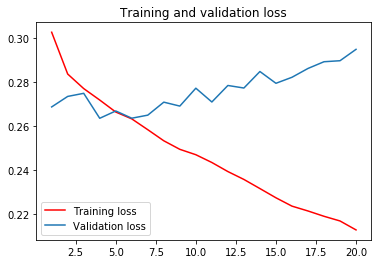

In [20]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Much better! We can significantly beat the commonsense baseline, demonstrating the value of machine learning as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.
The new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35°C after denormalization. That’s a solid gain on the initial error of 2.57°C, but we probably still have a bit of a margin for improvement.

### Use Recurrent Dropouts to Kill Overfitting
It’s evident from the training and validation curves that the model is overfitting: the training and validation losses start to diverge considerably after a few epochs. We’re already familiar with a classic technique for fighting this phenomenon: dropout,
which randomly zeros out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. But how to correctly apply dropout in recurrent networks isn’t a trivial question. It has long been known that
applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his PhD thesis on Bayesian deep learning, 6 determined the proper way to use dropout with a recurrent network: the same
dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that varies randomly from timestep to timestep. What’s more, in order to regularize the representations formed by the recurrent gates
of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its
learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process. 

Every recurrent layer in Keras has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, specifying the dropout rate of the recurrent units. Let’s add dropout and recurrent dropout to the GRU layer and see how doing so impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, we’ll train the network for twice as many epochs.


### Train and Evaluate a Dropout-regularized GRU-based Model

In [22]:
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.optimizers import RMSprop

In [23]:
model= Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))

In [24]:
model.compile(optimizer=RMSprop(), loss='mae')

In [26]:
history= model.fit_generator(train_gen, steps_per_epoch=500, epochs=40,
                            validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 161s 321ms/step - loss: 0.3351 - val_loss: 0.2761
Epoch 2/40
500/500 [==============================] - 159s 318ms/step - loss: 0.3162 - val_loss: 0.2715
Epoch 3/40
500/500 [==============================] - 165s 330ms/step - loss: 0.3109 - val_loss: 0.2708
Epoch 4/40
500/500 [==============================] - 164s 327ms/step - loss: 0.3045 - val_loss: 0.2698
Epoch 5/40
500/500 [==============================] - 159s 318ms/step - loss: 0.3013 - val_loss: 0.2683
Epoch 6/40
500/500 [==============================] - 159s 319ms/step - loss: 0.2987 - val_loss: 0.2651
Epoch 7/40
500/500 [==============================] - 165s 330ms/step - loss: 0.2949 - val_loss: 0.2695
Epoch 8/40
500/500 [==============================] - 159s 318ms/step - loss: 0.2968 - val_loss: 0.2646
Epoch 9/40
500/500 [==============================] - 159s 318ms/step - loss: 0.2933 - val_loss: 0.2651
Epoch 10/40
500/500 [==============================] - 160s 321m

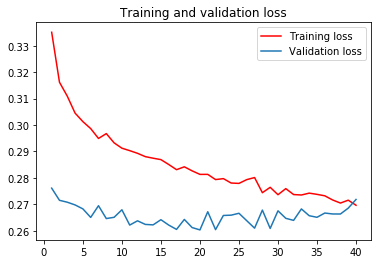

In [27]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We can see that the added layer does improve the results a bit, though not significantly. We can draw two conclusions:
    
 - Because you’re still not overfitting too badly, you could safely increase the size of our layers in a quest for validation-loss improvement. This has a non-negligible computational cost, though.
 - Adding a layer didn’t help by a significant factor, so we may be seeing diminishing returns from increasing network capacity at this point.
 
### Use bidirectional RNNs

The last technique introduced in this section is called **bidirectional RNNs**. A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. It’s frequently used in natural-language processing.

RNNs are notably order dependent, or time dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence. This is precisely
the reason they perform well on problems where order is meaningful, such as the temperature-forecasting problem. A bidirectional RNN exploits the order sensitivity of RNNs: it consists of using two regular RNNs, such as the GRU and LSTM layers we’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merging their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

Remarkably, the fact that the RNN layers in this section have processed sequences in chronological order (older timesteps first) may have been an arbitrary decision. At least, it’s a decision we made no attempt to question so far. Could the RNNs have performed well enough if they processed input sequences in antichronological order, for instance (newer timesteps first)? Let’s try this in practice and see what happens. All you need to do is write a variant of the data generator where the input sequences are reverted along the time dimension (replace the last line with yield `samples[:, ::-1, :]`, `targets`). Training the same one-GRU-layer network that we used in the first experiment in this section.

In [28]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [29]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 142s 285ms/step - loss: 0.4812 - val_loss: 0.4874
Epoch 2/20
500/500 [==============================] - 141s 282ms/step - loss: 0.4555 - val_loss: 0.4767
Epoch 3/20
500/500 [==============================] - 141s 282ms/step - loss: 0.4009 - val_loss: 0.4669
Epoch 4/20
500/500 [==============================] - 141s 281ms/step - loss: 0.3608 - val_loss: 0.4555
Epoch 5/20
500/500 [==============================] - 141s 281ms/step - loss: 0.3341 - val_loss: 0.4755
Epoch 6/20
500/500 [==============================] - 140s 281ms/step - loss: 0.3168 - val_loss: 0.4745
Epoch 7/20
500/500 [==============================] - 144s 287ms/step - loss: 0.3048 - val_loss: 0.4763
Epoch 8/20
500/500 [==============================] - 142s 283ms/step - loss: 0.2940 - val_loss: 0.4718
Epoch 9/20
500/500 [==============================] - 143s 286ms/step - loss: 0.2862 - val_loss: 0.4827
Epoch 10/20
500/500 [==============================] - 143s 286m

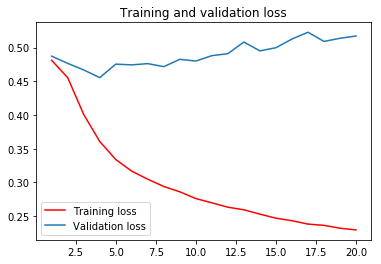

In [31]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()